In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler as SS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from config_store import features, targetDataSet
from utility_functions import dataSetSplit, doKFold, score

In [2]:
# Import and preview data set
data = pd.read_csv(targetDataSet)
data.head()

,Website,Packets,Bytes,Total Packets,Percent Filtered,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Duration,Bits/s A → B,Bits/s B → A
0,0,1,712,1256,0.08,1,712,0,0,16.763719,339,0
1,0,1,718,45,2.22,1,718,0,0,10.784664,532,0
2,0,1,889,28,3.57,1,889,0,0,4.927569,1443,0
3,0,1,712,1098,0.09,1,712,0,0,13.479684,422,0
4,0,1,718,52,1.92,1,718,0,0,12.706807,452,0


In [3]:
# Separate data set using test/train split
XTrain, XTest, yTrain, yTest = dataSetSplit(data.drop(columns = ["Website"]).values, data["Website"].values)

# Scale data
ss = SS()
XTrainScaled = ss.fit_transform(XTrain)
XTestScaled = ss.transform(XTest)

In [4]:
# Perform k-fold to optimize alpha hyperparameter
alphaRange = np.linspace(0, 0.3, 1000)

# Hold k-fold result for each possible k neighbor value
train = []
test = []
    
for alpha in alphaRange:
    rid_reg = Lasso(alpha=alpha)
    trainResult, testResult = doKFold(rid_reg, XTrainScaled, yTrain)
        
    train.append(np.mean(trainResult))
    test.append(np.mean(testResult))

c:\Users\okisn\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\okisn\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\okisn\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+02, tolerance: 7.028e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

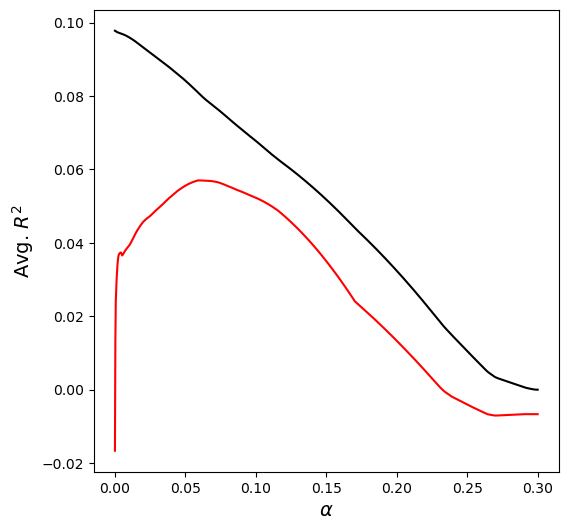

In [5]:
plt.figure(figsize=(6,6))
plt.plot(alphaRange, train, color='k', label='Training')
plt.plot(alphaRange, test, color='r', label='Testing')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Avg. $R^2$', fontsize=14)
plt.show()

In [6]:
# Get optimal hyperparameter for lasso
maxIndex = (test == np.max(test))
print(alphaRange[maxIndex])
print(np.max(test))
print(np.max(train))

[0.05945946]
0.05701028913690821
0.09776570378381841


In [7]:
# Final lasso model
lasso = Lasso(alpha=alphaRange[maxIndex][0])
lasso.fit(XTrainScaled, yTrain)

Lasso(alpha=0.059459459459459456)

In [8]:
# Score model
print("Model scores:")
score(lasso, XTrainScaled, yTrain, XTestScaled, yTest)

Model scores:
Training score: 0.07901303962804918
Testing score: 0.09961710276759195


In [9]:
# Report feature importance
print("Feature importance:")
for i in range(len(lasso.coef_)):
    print("{} \t{:>30}".format(features[i], lasso.coef_[i]))

Feature importance:
Packets 	                          -0.0
Bytes 	                          -0.0
Total Packets 	                          -0.0
Percent Filtered 	                          -0.0
Packets A → B 	           -0.2372374554857474
Bytes A → B 	                           0.0
Packets B → A 	                          -0.0
Bytes B → A 	                          -0.0
Duration 	           0.22847746294272858
Bits/s A → B 	           0.04975584836190915
Bits/s B → A 	                          -0.0


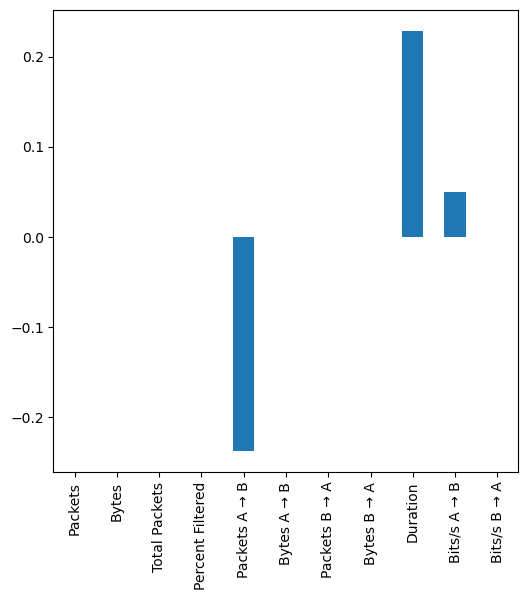

In [10]:
lassoCoef = pd.Series(lasso.coef_)
plt.figure(figsize=(6,6))
lassoCoef.plot.bar()
plt.xticks(np.array(range(0, 11)), features)
plt.show()

In [11]:
alphaRange = np.linspace(0, 0.3, 100)
lassoCoef = []
for alpha in alphaRange:
    lasso = Lasso(alpha = alpha)
    lasso.fit(XTrainScaled, yTrain)
    lassoCoef.append(lasso.coef_)

c:\Users\okisn\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\okisn\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\okisn\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.564e+02, tolerance: 7.878e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

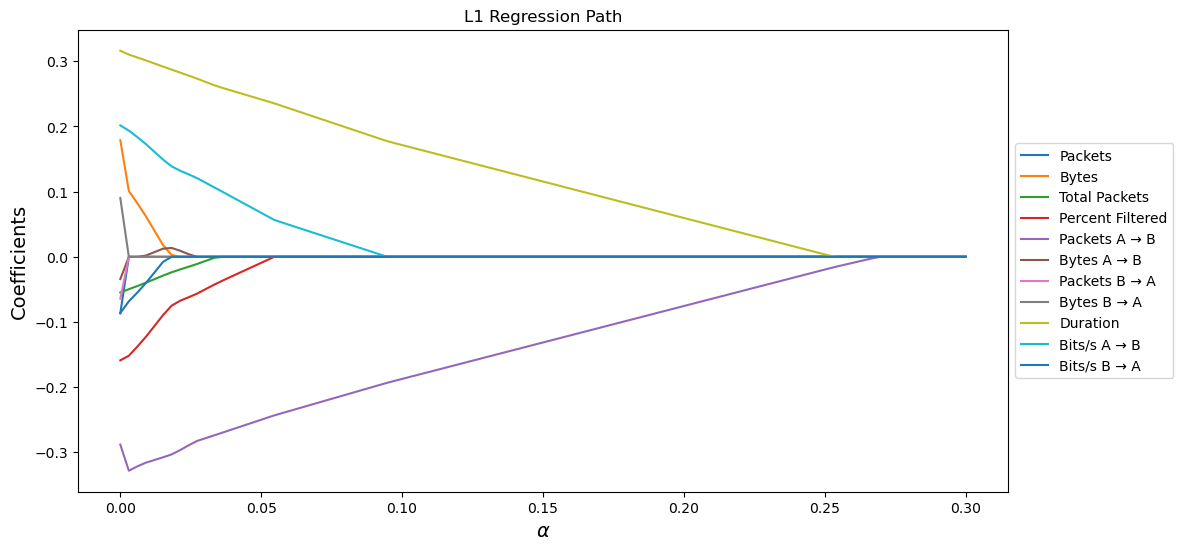

In [13]:
plt.figure(figsize=(12,6))
plt.plot(alphaRange, lassoCoef)
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.legend(data.drop(columns = "Website"), bbox_to_anchor=[1,0.5], loc='center left')
plt.title("L1 Regression Path")
plt.show()

# Extra Data Analysis

In [14]:
# Check correlation of variables
data.corr()

,Website,Packets,Bytes,Total Packets,Percent Filtered,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Duration,Bits/s A → B,Bits/s B → A
Website,1.000000,-0.029261,0.043369,-0.007184,-0.036832,-0.203511,-0.051300,0.052957,0.055845,0.195790,0.004201,0.058970
Packets,-0.029261,1.000000,0.936578,-0.043861,0.642099,0.022004,-0.150549,0.919306,0.912883,-0.041908,-0.039353,0.552012
Bytes,0.043369,0.936578,1.000000,-0.071996,0.588835,-0.186987,-0.087739,0.942720,0.952345,-0.050029,-0.017568,0.584859
Total Packets,-0.007184,-0.043861,-0.071996,1.000000,-0.230188,0.053563,-0.022917,-0.061786,-0.059613,0.324409,-0.150527,-0.045623
Percent Filtered,-0.036832,0.642099,0.588835,-0.230188,1.000000,-0.071688,-0.155470,0.624066,0.592560,-0.211914,0.483326,0.320079
Packets A → B,-0.203511,0.022004,-0.186987,0.053563,-0.071688,1.000000,0.652051,-0.373220,-0.372713,0.104297,0.070009,-0.439596
Bytes A → B,-0.051300,-0.150549,-0.087739,-0.022917,-0.155470,0.652051,1.000000,-0.396378,-0.387403,0.112907,0.145298,-0.467342
Packets B → A,0.052957,0.919306,0.942720,-0.061786,0.624066,-0.373220,-0.396378,1.000000,0.993840,-0.079945,-0.064077,0.685292
Bytes B → A,0.055845,0.912883,0.952345,-0.059613,0.592560,-0.372713,-0.387403,0.993840,1.000000,-0.080873,-0.060750,0.684377
Duration,0.195790,-0.041908,-0.050029,0.324409,-0.211914,0.104297,0.112907,-0.079945,-0.080873,1.000000,-0.227898,-0.069038


<Axes: >

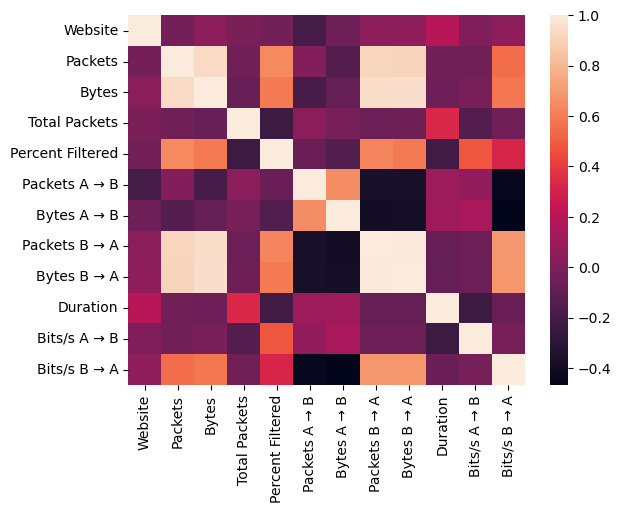

In [15]:
# Create correlation heatmap
sns.heatmap(data.corr())

In [16]:
# Make new scaled X set
XData = SS().fit_transform(data.drop(columns = ["Website"]))

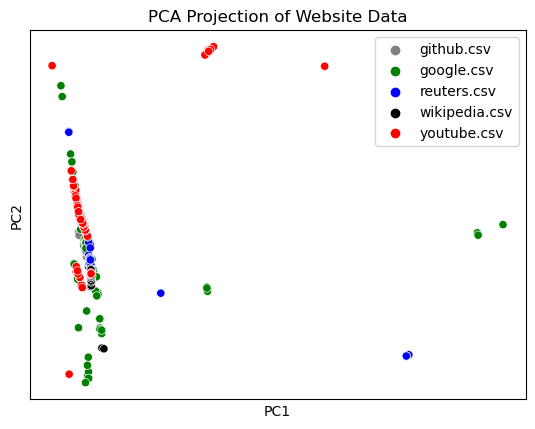

In [20]:
# Make PCA
pca = PCA()
XPCA = pca.fit_transform(XData)
pcaData = pd.DataFrame(XPCA[:, :2], columns = ["PC1", "PC2"])
pcaData["Website"] = data["Website"]

#  Plot PCA
ax = sns.scatterplot(data = pcaData, x = "PC1", y = "PC2", hue = "Website", palette = ["gray", "green", "blue", "black", "red"])
plt.legend(ax.get_legend_handles_labels()[0], ["github.csv", "google.csv", "reuters.csv", "wikipedia.csv", "youtube.csv"])
plt.xticks([])
plt.yticks([])
plt.title("PCA Projection of Website Data")
plt.show()

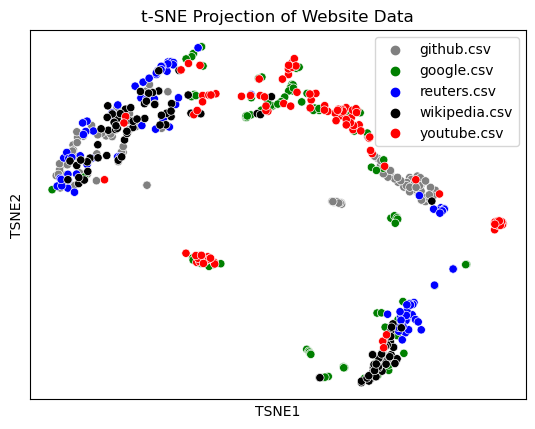

In [19]:
# Make TSNE
tsne = TSNE()
XTSNE = tsne.fit_transform(XData)
tsneData = pd.DataFrame(XTSNE[:, :2], columns = ["TSNE1", "TSNE2"])
tsneData["Website"] = data["Website"]

#  Plot TSNE
ax = sns.scatterplot(data = tsneData, x = "TSNE1", y = "TSNE2", hue = "Website", palette = ["gray", "green", "blue", "black", "red"])
plt.legend(ax.get_legend_handles_labels()[0], ["github.csv", "google.csv", "reuters.csv", "wikipedia.csv", "youtube.csv"])
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Projection of Website Data")
plt.show()